In [63]:
# Лабораторная работа 5_2
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

In [64]:
# Загрузка данных
try:
    df = pd.read_csv('diabetes.csv')
    print("Первые 5 строк данных:")
    display(df.head())
except FileNotFoundError:
    print("Файл 'diabetes.csv' не найден. Пожалуйста, загрузите его с Kaggle")
    df = None

Первые 5 строк данных:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [65]:
# Подготовка данных
if df is not None:
    X = df.drop('Outcome', axis=1)
    y = df['Outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Масштабирование для XGBoost
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

In [66]:
# Функция для оценки моделей
def evaluate_model(y_true, y_pred, model_name, training_time=None):
    print(f"\nРезультаты для модели {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1-score: {f1_score(y_true, y_pred):.4f}")
    print("\nМатрица ошибок:")
    print(confusion_matrix(y_true, y_pred))
    print("\nОтчет классификации:")
    print(classification_report(y_true, y_pred))
    if training_time:
        print(f"Время обучения: {training_time:.2f} секунд")

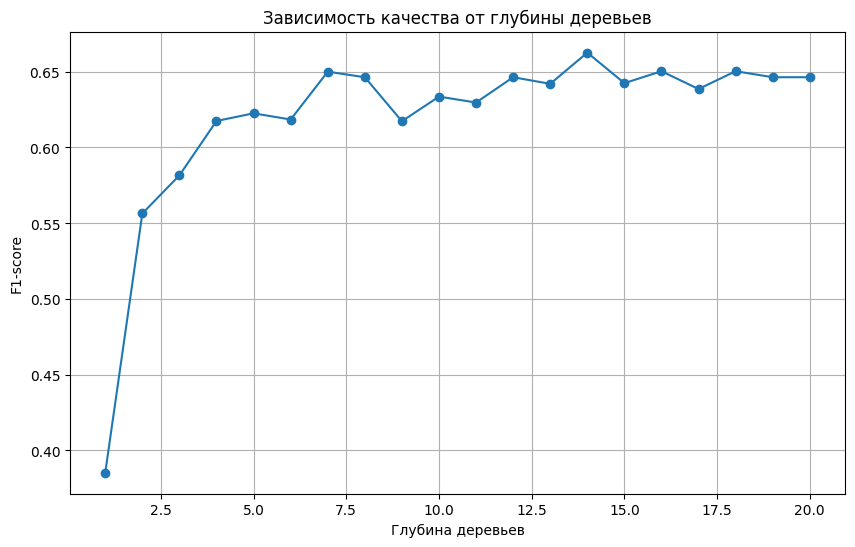

In [67]:
## Случайный лес
# Исследование зависимости качества от глубины деревьев
if 'X_train' in locals():
    depths = range(1, 21)
    f1_scores = []

    for depth in depths:
        rf = RandomForestClassifier(max_depth=depth, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred))

    plt.figure(figsize=(10, 6))
    plt.plot(depths, f1_scores, marker='o')
    plt.xlabel('Глубина деревьев')
    plt.ylabel('F1-score')
    plt.title('Зависимость качества от глубины деревьев')
    plt.grid()
    plt.show()

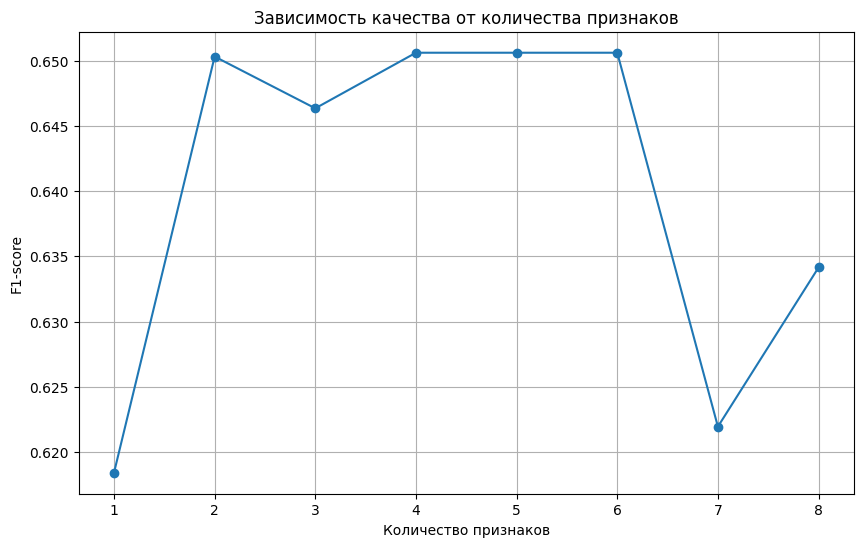

In [68]:
# Исследование зависимости качества от количества признаков
if 'X_train' in locals():
    max_features = range(1, X.shape[1]+1)
    f1_scores = []

    for features in max_features:
        rf = RandomForestClassifier(max_features=features, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred))

    plt.figure(figsize=(10, 6))
    plt.plot(max_features, f1_scores, marker='o')
    plt.xlabel('Количество признаков')
    plt.ylabel('F1-score')
    plt.title('Зависимость качества от количества признаков')
    plt.xticks(max_features)
    plt.grid()
    plt.show()

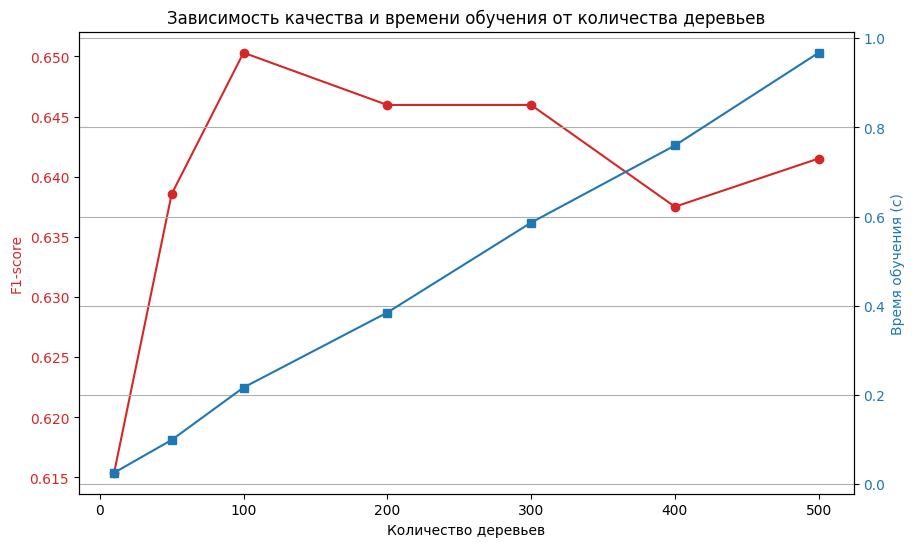

In [69]:
# Исследование зависимости качества от количества деревьев
if 'X_train' in locals():
    n_estimators = [10, 50, 100, 200, 300, 400, 500]
    f1_scores = []
    training_times = []

    for n in n_estimators:
        start_time = time.time()
        rf = RandomForestClassifier(n_estimators=n, random_state=42)
        rf.fit(X_train, y_train)
        training_time = time.time() - start_time
        y_pred = rf.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred))
        training_times.append(training_time)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:red'
    ax1.set_xlabel('Количество деревьев')
    ax1.set_ylabel('F1-score', color=color)
    ax1.plot(n_estimators, f1_scores, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Время обучения (с)', color=color)
    ax2.plot(n_estimators, training_times, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Зависимость качества и времени обучения от количества деревьев')
    plt.grid()
    plt.show()

In [70]:
## XGBoost
# Базовый вариант XGBoost
if 'X_train_scaled' in locals():
    start_time = time.time()
    xgb = XGBClassifier(random_state=42)
    xgb.fit(X_train_scaled, y_train)
    training_time = time.time() - start_time
    y_pred = xgb.predict(X_test_scaled)
    evaluate_model(y_test, y_pred, "XGBoost (базовый)", training_time)


Результаты для модели XGBoost (базовый):
Accuracy: 0.7273
F1-score: 0.6228

Матрица ошибок:
[[116  35]
 [ 28  52]]

Отчет классификации:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       151
           1       0.60      0.65      0.62        80

    accuracy                           0.73       231
   macro avg       0.70      0.71      0.70       231
weighted avg       0.73      0.73      0.73       231

Время обучения: 0.06 секунд


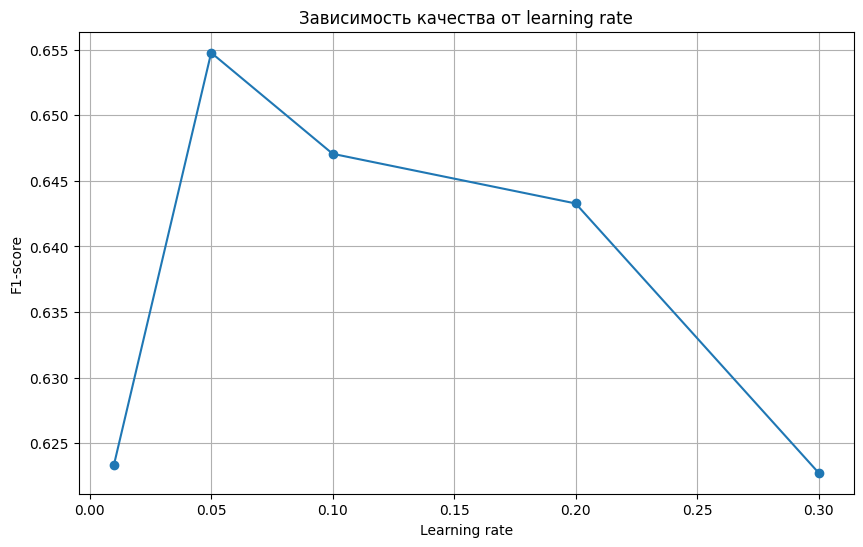

In [71]:
# Подбор параметров XGBoost
if 'X_train_scaled' in locals():
    # Исследуем learning_rate
    learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
    f1_scores = []

    for lr in learning_rates:
        xgb = XGBClassifier(learning_rate=lr, random_state=42)
        xgb.fit(X_train_scaled, y_train)
        y_pred = xgb.predict(X_test_scaled)
        f1_scores.append(f1_score(y_test, y_pred))

    plt.figure(figsize=(10, 6))
    plt.plot(learning_rates, f1_scores, marker='o')
    plt.xlabel('Learning rate')
    plt.ylabel('F1-score')
    plt.title('Зависимость качества от learning rate')
    plt.grid()
    plt.show()

In [72]:
# Оптимизированная модель XGBoost
if 'X_train_scaled' in locals():
    start_time = time.time()
    xgb_optimized = XGBClassifier(
        learning_rate=0.1,
        max_depth=3,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    xgb_optimized.fit(X_train_scaled, y_train)
    training_time = time.time() - start_time
    y_pred = xgb_optimized.predict(X_test_scaled)
    evaluate_model(y_test, y_pred, "XGBoost (оптимизированный)", training_time)


Результаты для модели XGBoost (оптимизированный):
Accuracy: 0.7273
F1-score: 0.6272

Матрица ошибок:
[[115  36]
 [ 27  53]]

Отчет классификации:
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       151
           1       0.60      0.66      0.63        80

    accuracy                           0.73       231
   macro avg       0.70      0.71      0.71       231
weighted avg       0.74      0.73      0.73       231

Время обучения: 0.06 секунд


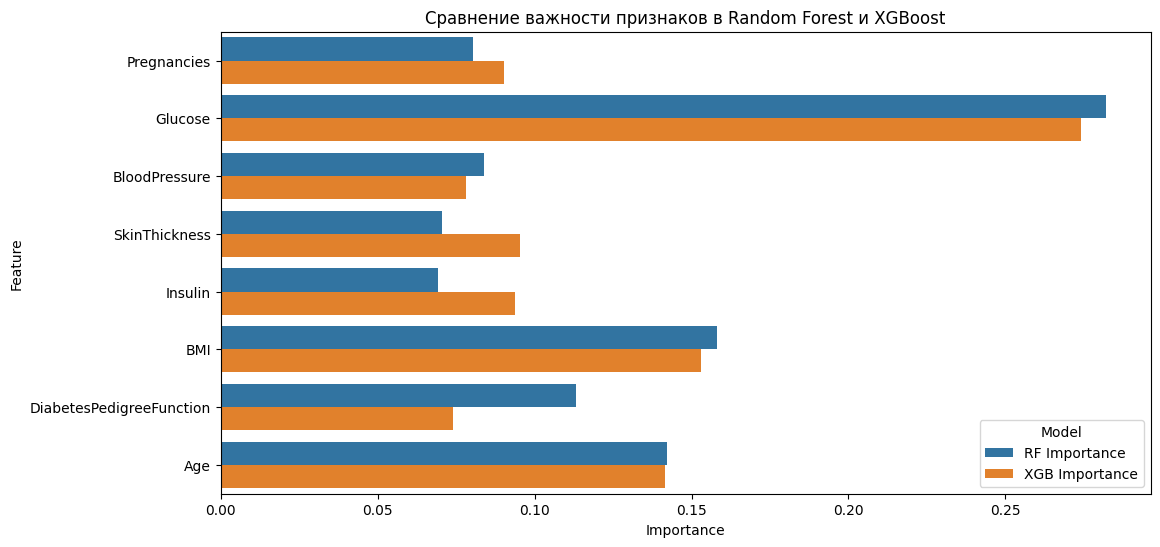

In [73]:
# Сравнение важности признаков
if 'X_train' in locals():
    # Для Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    # Для XGBoost
    xgb = XGBClassifier(random_state=42)
    xgb.fit(X_train_scaled, y_train)

    # Создаем DataFrame для визуализации
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'RF Importance': rf.feature_importances_,
        'XGB Importance': xgb.feature_importances_
    }).melt(id_vars='Feature', var_name='Model', value_name='Importance')

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', hue='Model', data=feature_importance)
    plt.title('Сравнение важности признаков в Random Forest и XGBoost')
    plt.show()